# Проект: модель определения приблизительного возраста человека

Описание задачи: cетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.
Наша цель - построить модель, которая по фотографии определит приблизительный возраст человека. Для обучения модели у нас есть набор фотографий людей с указанием их возраста.

# Исследовательский анализ данных

In [1]:
# Загрузим необходимые библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Зафиксируем константы:
TEST_SIZE = 0.25
RANDOM_STATE = 1897

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет состоит из 7591 позиции. Проверим на наличие пропущенных значений и явных дубликатов:

In [5]:
data.isna().sum()

file_name    0
real_age     0
dtype: int64

In [6]:
data.index.duplicated().sum()

0

In [7]:
# И те, и другие отсутствуют. Посмотрим описание датасета:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


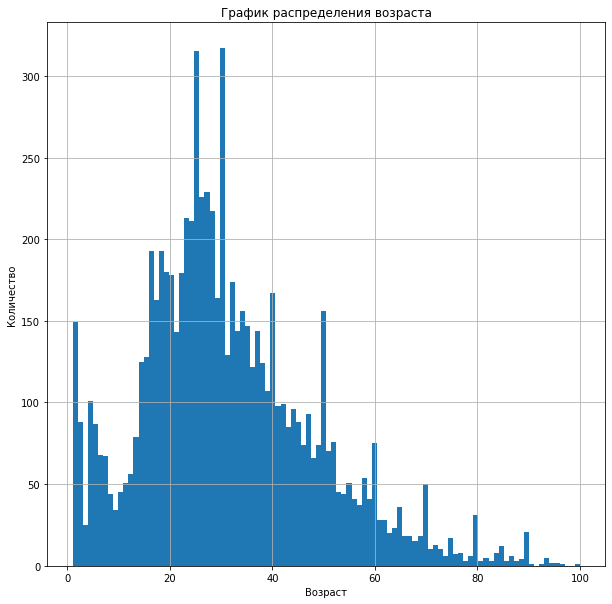

In [8]:
# Построим график распределения возраста в выборке:
plt.figure(figsize=(10, 10))
plt.hist(data['real_age'], bins=100)
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True);

Распределение нормальное, возраст представлен от одного года до 100 лет, с пиком в диапазоне 25-30 лет. Напечатаем на экране 15 фотографий из датасета, предварительно выполнив следующие шаги:

In [9]:
# Создадим генератор изображений с масштабированием пикселей (rescale=1/255.)
datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Запишем в переменную путь к папке с изображениями
dataset_path = '/datasets/faces/final_files/'

In [11]:
# Создадим генератор данных
data_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=dataset_path,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 7591 validated image filenames.


In [12]:
# Извлечём первую партию из генератора
images, ages = next(data_generator)

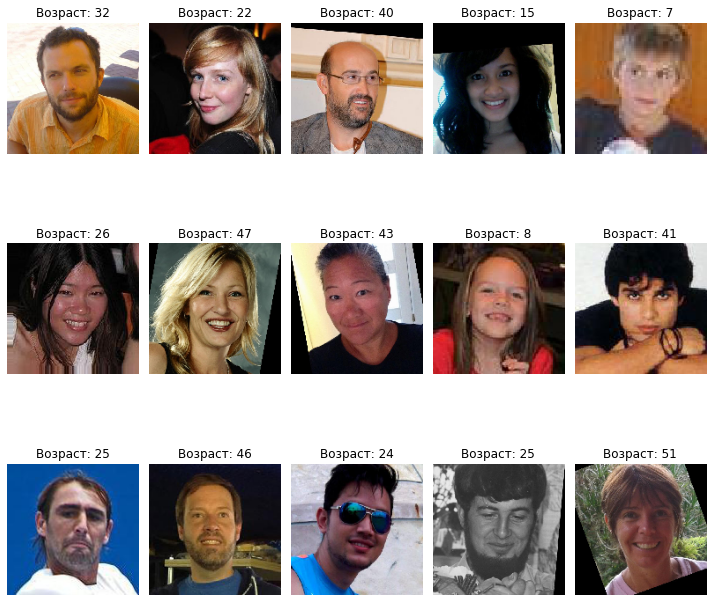

In [13]:
# Выведем на экран 15 фотографий с подписанным возрастом их обладателей
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)  # Создадим сетку для отображения (3 строки x 5 столбцов)
    plt.imshow(images[i])   # Покажем изображение
    plt.title(f'Возраст: {ages[i]}')  # Добавим метку
    plt.axis('off')          # Уберём оси
plt.tight_layout()           # Оптимизируем размещение
plt.show()

Выводы по разделу:
- загрузили данные из 7591 позиции, пропущенные значения и явные дубликаты отсутствуют;
- построили график распределения возраста в выборке: распределение нормальное, выбросы отсутствуют, возраст обладателей фотографий - от одного года до 100 лет. Эти крайние значения - не сильно репрезентативная аудитория, но, теме не менее, по таким данным тоже можно обучать модель;
- вывели на экран 15 фотографий из выборки, подписали реальный возраст над каждой. Модели может быть не так просто определить возраст человека, т.к. могут помешать такие детали, как очки, борода, качество фотографии и т.д.

# Подготовка данных к обучению, обучение модели

Код запускали в отдельном GPU-тренажёре, поэтому ниже он оформлен в единой ячейке, без её запуска:

In [ ]:
# Загружаем библиотеки
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Фиксируем константы
TEST_SIZE = 0.25
RANDOM_STATE = 1897

# Функция загрузки тренировочных данных
def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    # rescale=1./255 - нормализуем значения пикселей к диапазону [0, 1]
    datagen = ImageDataGenerator(validation_split=TEST_SIZE, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw', # выходные данные не категорийные, а числовые
        subset='training',
        seed=RANDOM_STATE)
 
    return train_gen_flow

# Функция загрузки тестовых данных 
def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=RANDOM_STATE)
 
    return test_gen_flow

# Создание модели нейронной сети
def create_model(input_shape):

    # Загружаем архитектуру ResNet50:
    # input_shape=input_shape - задаём размерность входного изображения
    # weights='imagenet' - используем предобученные веса на ImageNet
    # include_top=False - удаляем полносвязные слои сверху, чтобы использовать сеть как backbone
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    # Создаём последовательную модель
    model = Sequential()
    # Добавляем backbone (ResNet50)
    model.add(backbone)
    # Добавляем слой глобального усреднения по всем пространственным координатам
    model.add(GlobalAveragePooling2D())
    # Добавляем слой Dense (полносвязный) на один выходной нейрон с ReLU-активацией
    model.add(Dense(1, activation='relu'))
    
    # Инициализируем оптимизатор Adam с определенной скоростью обучения
    optimizer = Adam(lr=0.0001)
    # Компилируем модель: используем среднеквадратичную ошибку (MSE) как функцию потерь
    # и MAE (средняя абсолютная ошибка) как метрику прогнозирования
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model

# Обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    # Если количество шагов на эпоху не задано,
    # устанавливаем его как длину (количество батчей) тренировочных данных
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    # Если шаги на валидации не заданы,
    # устанавливаем как длину тестовых данных
    if validation_steps is None:
        validation_steps = len(test_data)
 
    # Запускаем процесс обучения модели
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

Результат выполнения программы и подсчёта метрики MAE на тестовом наборе данных:

Выводы по разделу:
- загрузили необходимые библиотеки в GPU-тренажёре, зафиксировали константы;
- создали функции: загрузки тренировочных данных, тестовых данных, создания модели нейронной сети, обучения модели;
- в результате получили значение метрики МАЕ на тестовых данных, равное 6.4, что соответствует требованиям задачи (не больше 8).

# Итоговый вывод.

В результате обучения модели получили значение метрики MAE на тестовой выборке равное 6.4 года, что достаточно хороший показатель качества модели для первой цели исследования (анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы), но может быть критично для второй цели (контролировать добросовестность кассиров при продаже алкоголя). Для одновременного достижения двух задач требуется улучшение модели.